In [11]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [12]:
path_train = "/content/Alzheimer_s Dataset/train"
path_test = "/content/Alzheimer_s Dataset/test"

train_rescale = ImageDataGenerator(rescale=1./255)
test_rescale = ImageDataGenerator(rescale=1./255)

train_data = train_rescale.flow_from_directory(
    path_train,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)


test_data = test_rescale.flow_from_directory(
    path_test,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [13]:
#VGG-16 Model

vgg16_model_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model_base.layers:
    layer.trainable = False

x = Flatten()(vgg16_model_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Optional: Add dropout for regularization
x = Dense(4, activation='softmax')(x)  # Assuming 4 classes

# Define the new model
vgg16_model = Model(inputs=vgg16_model_base.input, outputs=x)

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

vgg_history = vgg16_model.fit(
        train_data,
        steps_per_epoch=train_data.samples // train_data.batch_size,
        validation_data=test_data,
        epochs=10  # You can adjust the number of epochs
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1205s 7s/step - accuracy: 0.4883 - loss: 1.1563 - val_accuracy: 0.5168 - val_loss: 0.9423
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.3750 - loss: 1.1101 - val_accuracy: 0.5192 - val_loss: 0.9509
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1346s 8s/step - accuracy: 0.5654 - loss: 0.8986 - val_accuracy: 0.5653 - val_loss: 0.9135
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.5625 - loss: 0.8207 - val_accuracy: 0.5809 - val_loss: 0.8962
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17868s 112s/step - accuracy: 0.5987 - loss: 0.8456 - val_accuracy: 0.5911 - val_loss: 0.8546
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.6562 - loss: 0.7892 - val_accuracy: 0.5809 - val_loss: 0.8578
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1191s 7s/step - accuracy: 0.6587 - loss: 0.7735 - val_accuracy: 0.5856 - val_loss: 0.8647
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.7188 - loss: 0.7415 - v

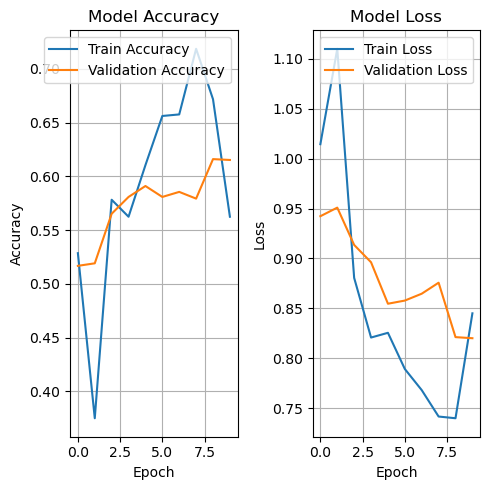

In [24]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(5, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
test_loss, test_acc = vgg16_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.6186 - loss: 0.8031
Test Loss: 0.8200418949127197
Test Accuracy: 0.6153244972229004


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the classes on the test set
predictions = vgg16_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(class_report)

40/40 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step
[[  3   0 127  49]
 [  0   0   7   5]
 [  9   0 471 160]
 [ 14   0 328 106]]
                  precision    recall  f1-score   support

    MildDemented       0.12      0.02      0.03       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.74      0.60       640
VeryMildDemented       0.33      0.24      0.28       448

        accuracy                           0.45      1279
       macro avg       0.24      0.25      0.23      1279
    weighted avg       0.38      0.45      0.40      1279

